In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [2]:
# Read training file
df = pd.read_csv("train_data_withlabels.csv")
# Rename first column 
df.rename(columns={'Unnamed: 0': "Time"}, inplace = True)
# Encode day of week column from categorical to numeric
df['dayofweek'] = df['dayofweek'].replace({'Sun': 0, 'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat': 6})
# Drop Time COlumn
df.drop('Time', axis = 1, inplace=True)

# Read test data with no lables
df_test = pd.read_csv("test_data_nolabels.csv")
df_test.rename(columns={'Unnamed: 0': "Time"}, inplace = True)
# Encode day of week column from categorical to numeric
df_test['dayofweek'] = df_test['dayofweek'].replace({'Sun': 0, 'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat': 6})

Id = df_test['Time']
df_test.drop('Time', axis=1, inplace = True)

In [3]:
# Taking count of all the labels
print("Label count for AC: \n", df.ac.value_counts())
print("\nLabel count for EV: \n", df.ev.value_counts())
print("\nLabel count for Oven: \n",df.oven.value_counts())
print("\nLabel count for Wash: \n", df.wash.value_counts())
print("\nLabel count for Dryer: \n",df.dryer.value_counts())

Label count for AC: 
 0    316521
1    101199
Name: ac, dtype: int64

Label count for EV: 
 0    415385
1      2335
Name: ev, dtype: int64

Label count for Oven: 
 0    411764
1      5956
Name: oven, dtype: int64

Label count for Wash: 
 0    409767
1      7953
Name: wash, dtype: int64

Label count for Dryer: 
 0    404144
1     13576
Name: dryer, dtype: int64


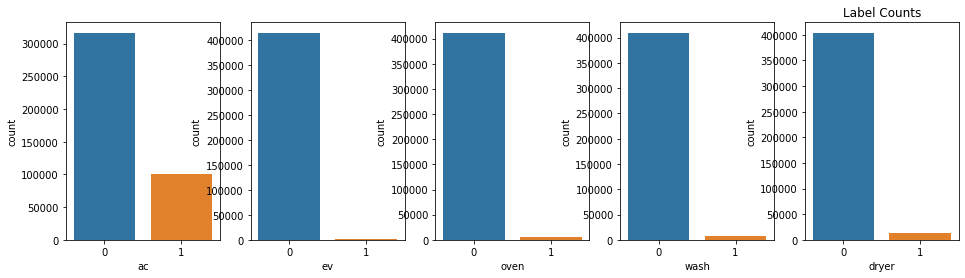

In [4]:
plt.rcParams['figure.figsize'] = [16, 4]

# sns.countplot(x=df['ac'])
fig, ax =plt.subplots(1,5)
sns.countplot(df['ac'], ax=ax[0])
sns.countplot(df['ev'], ax=ax[1])
sns.countplot(df['oven'], ax=ax[2])
sns.countplot(df['wash'], ax=ax[3])
sns.countplot(df['dryer'], ax=ax[4])
plt.title("Label Counts")
fig.show()

As we can see above from the count plots that there is big imbalance between target values for all the appliances. **For AC**, the difference is almost 3 times, and **for EV, Oven, Wash, and Dryer** difference is compare to 1 is almost 200, 100, 80, 70 times respectively against target value 0.

In [5]:
# Getting the correlation heat map
df.corr().style.background_gradient(cmap='coolwarm')

From above corrwlation map we can figure out following:<br>
- Label AC is highly correlated with feature load, that is 0.908, and then partially correlated to max and var feature.
- For other labels EV, Oven, Wash, Dryer as we can see there is no high/partially both positive or negative correlation with any feature.
- But amoung features, max and var are again highly correlated.
- There is negative correlation of -0.675 between hurst and entropy.

#### Label AC load distribution

Text(0.5, 1.0, 'AC load distribution')

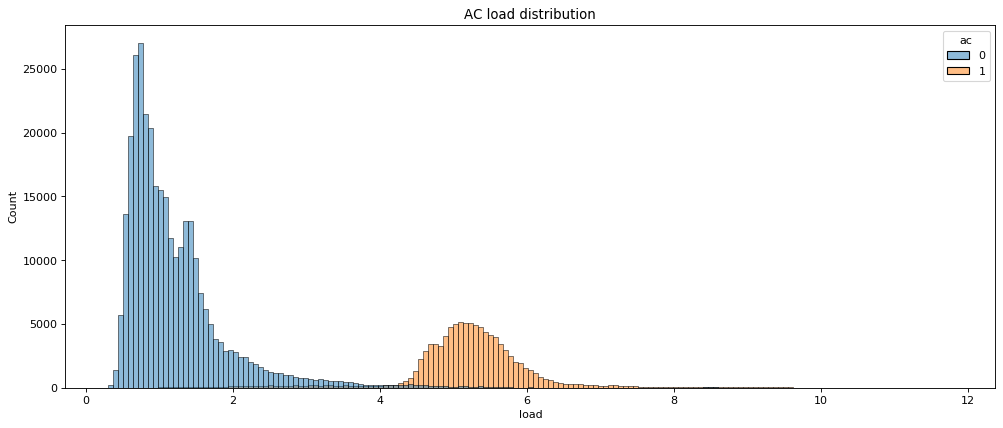

In [6]:
figure(figsize=(15, 6), dpi=80)
sns.histplot(data=df, x="load", hue="ac")
plt.title("AC load distribution")

#### Label EV load distribution

<Figure size 1200x640 with 0 Axes>

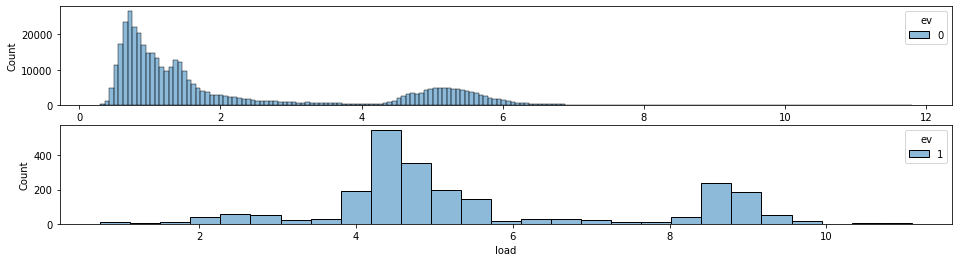

In [7]:
figure(figsize=(15, 8), dpi=80)
fig, ax =plt.subplots(2,1)
sns.histplot(data=df[df['ev'] == 0], x="load", hue="ev", ax = ax[0])
sns.histplot(data=df[df['ev'] == 1], x="load", hue="ev", ax = ax[1])

#### Label Oven load distribution

<Figure size 1200x640 with 0 Axes>

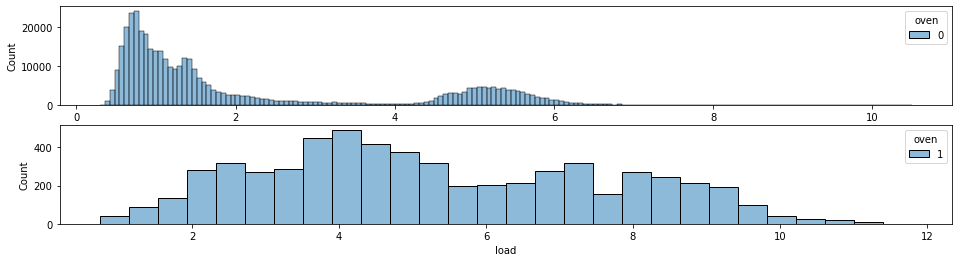

In [8]:
figure(figsize=(15, 8), dpi=80)
fig, ax =plt.subplots(2,1)
sns.histplot(data=df[df['oven'] == 0], x="load", hue="oven", ax = ax[0])
sns.histplot(data=df[df['oven'] == 1], x="load", hue="oven", ax = ax[1])

#### Label Wash load distribution

<Figure size 1200x800 with 0 Axes>

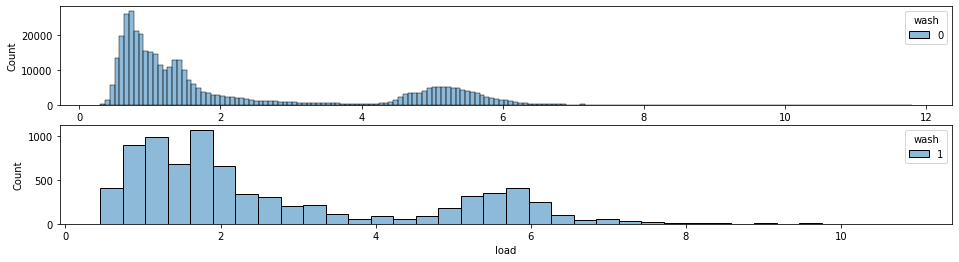

In [9]:
figure(figsize=(15, 10), dpi=80)
fig, ax =plt.subplots(2,1)
sns.histplot(data=df[df['wash'] == 0], x="load", hue="wash", ax = ax[0])
sns.histplot(data=df[df['wash'] == 1], x="load", hue="wash", ax = ax[1])

#### Label Dryer load distribution

<Figure size 1200x800 with 0 Axes>

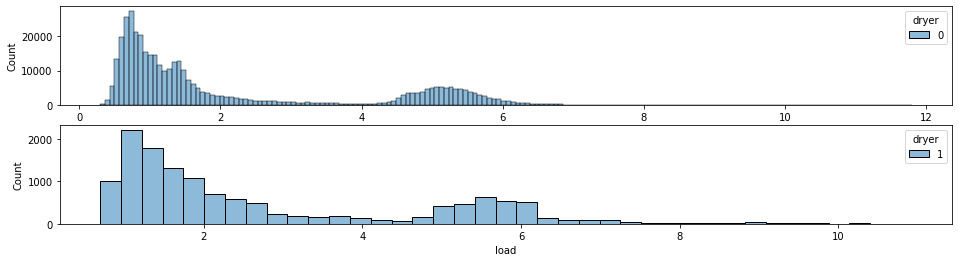

In [10]:
figure(figsize=(15, 10), dpi=80)
fig, ax =plt.subplots(2,1)
sns.histplot(data=df[df['dryer'] == 0], x="load", hue="dryer", ax = ax[0])
sns.histplot(data=df[df['dryer'] == 1], x="load", hue="dryer", ax = ax[1])

### Sampling Function

In [11]:
def sample(appliance, x=1):
    # get label name
    txt = appliance
    # select all rows having lable value 0
    ac_off = df[df[txt] == 0]
    # select all rows having lable value 1
    ac_on = df[df[txt] == 1]
    # create a limiter
    limit = len(ac_on) * x
    # limit the number of data points
    ac_off = ac_off.sample(n = limit)
    # Concat the data for 0 and 1
    df_ac = pd.concat([ac_off, ac_on])
    # get the label 
    Y = df_ac[txt]
    # get all the features and remove target variables
    X = df_ac[[x for x in df_ac.columns if (x != 'ac') and (x != 'ev') and (x != 'oven') and (x != 'wash') and (x != 'dryer')]]
    
    return X,Y

### Training/Testing Data and SMOTE for AC

In [12]:
# Training and testing data
# calling the sample fucntion for ac label
X,Y = sample("ac",2)

# create SMOTE object
sm = SMOTE()

# Resample the data
X_sm, y_sm = sm.fit_resample(X, Y)

print("Dimension of X dataframe before SMOTE: {} \nDimension of X dataframe after SMOTE: {}".format(X.shape, X_sm.shape))

print('\npositive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

# split data in training and testing 80 training and 20 testing
X_train, X_test, y_train, y_test = train_test_split(X_sm,y_sm, test_size=0.2, random_state=13)

Dimension of X dataframe before SMOTE: (303597, 10) 
Dimension of X dataframe after SMOTE: (404796, 10)

positive and negative classes (%):


In [13]:
for i in range(1,len(X_train.columns)):
    XGB = XGBClassifier(eval_metric = 'logloss') 
    ac_fs = RFE(XGB, n_features_to_select=i, step=1).fit(X_train, y_train)
    ac_fs.get_support()
    print(X_train.columns[ac_fs.get_support()])

### XG Boost for AC

[23:33:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 Score at training data:  [0.99515246 0.99513891]

Confusion Matrix for training data: 
 [[161358    691]
 [   881 160906]]

ON Testing SET-----------------------

F1 Score at testing data:  [0.99233427 0.99237412]

Confusion Matrix for testing data: 
 [[40065   284]
 [  335 40276]]


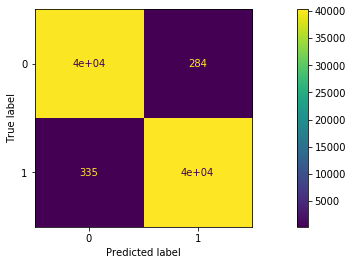

In [14]:
# Keeping relevent features only
X_train = X_train[['load', 'hourofday', 'dayofweek', 'absdif', 'max', 'var', 'hurst']]
X_test = X_test[['load', 'hourofday', 'dayofweek', 'absdif', 'max', 'var', 'hurst']]

# create XGB object
XGB = XGBClassifier()
# fit the model on training set
XGB.fit(X_train, y_train)
# predcit the data on training set
y_pred = XGB.predict(X_train)
# get the confusion matrix
matrix = confusion_matrix(y_train, y_pred)

print("F1 Score at training data: ", f1_score(y_train, y_pred, average=None))

print("\nConfusion Matrix for training data: \n", matrix)
print("\nON Testing SET-----------------------\n")

# predcit the data on testing set
y_pred = XGB.predict(X_test)
# get the confusion matrix for testing set
matrix = confusion_matrix(y_test, y_pred)

print("F1 Score at testing data: ",f1_score(y_test, y_pred, average=None))

print("\nConfusion Matrix for testing data: \n",matrix)

plot_confusion_matrix(XGB, X=X_test, y_true= y_test)

In [15]:
# Cross Validation
cv = KFold(n_splits=10)
n_scores = cross_val_score(XGB, X_test, y_test, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('F1: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
print("Score for each validation and testing set", n_scores)

F1: 0.991 (0.001)
Score for each validation and testing set [0.99110949 0.98988385 0.99195445 0.99024152 0.9905417  0.99070385
 0.98896192 0.99207332 0.99154439 0.99162768]


In [16]:
# Predicting on test set AC label
ac_1 = XGB.predict(df_test[['load', 'hourofday', 'dayofweek', 'absdif', 'max', 'var', 'hurst']])

In [17]:
a = XGB.predict(df[['load', 'hourofday', 'dayofweek', 'absdif', 'max', 'var', 'hurst']])
print("F1 Score for all training data: ",f1_score(df['ac'], a, average=None))
matrix = confusion_matrix(df['ac'], a)
print("\nConfusion Matrix for all training data: \n", matrix)

F1 Score for all training data:  [0.99614849 0.98803814]

Confusion Matrix for all training data: 
 [[314763   1758]
 [   676 100523]]


### Training/Testing Data and SMOTE for EV

In [18]:
# Training and testing data
X,Y = sample("ev",8)

X_sm, y_sm = sm.fit_resample(X, Y)

print("Dimension of X dataframe before SMOTE: {} \nDimension of X dataframe after SMOTE: {}".format(X.shape, X_sm.shape))

print('\npositive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

# split data in training and testing 80 training and 20 testing
X_train_ev, X_test_ev, y_train_ev, y_test_ev = train_test_split(X_sm,y_sm, test_size=0.2, random_state=13)


Dimension of X dataframe before SMOTE: (21015, 10) 
Dimension of X dataframe after SMOTE: (37360, 10)

positive and negative classes (%):


In [19]:
for i in range(1,len(X_train_ev.columns)):
    XGB_ev = XGBClassifier(eval_metric = 'logloss') 
    ac_fs = RFE(XGB_ev, n_features_to_select=i, step=1).fit(X_train_ev, y_train_ev)
    ac_fs.get_support()
    print(X_train_ev.columns[ac_fs.get_support()])
    
    ac_rf_pred = ac_fs.predict(X = X_test_ev)
    print(confusion_matrix(y_true = y_test_ev, y_pred = ac_rf_pred))

### XG Boost for EV

[23:34:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 Score at training data:  [1. 1.]

Confusion Matrix for training data: 
 [[14886     0]
 [    0 15002]]

ON Testing SET-----------------------

F1 Score at testing data:  [0.99498548 0.99484116]

Confusion Matrix for testing data: 
 [[3770   24]
 [  14 3664]]


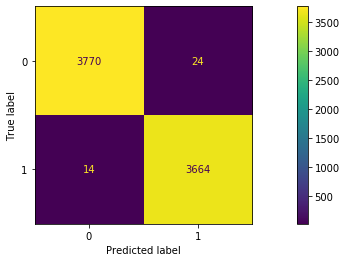

In [20]:
X_train_ev = X_train_ev[['load', 'hourofday', 'dayofweek', 'max', 'var', 'hurst']]
X_test_ev = X_test_ev[['load', 'hourofday', 'dayofweek', 'max', 'var', 'hurst']]

# create XGB object
XGB_ev = XGBClassifier()
# fit the model on training set
XGB_ev.fit(X_train_ev, y_train_ev)
# predcit the data on training set
y_pred_ev = XGB_ev.predict(X_train_ev)
# get the confusion matrix
matrix = confusion_matrix(y_train_ev, y_pred_ev)

print("F1 Score at training data: ", f1_score(y_train_ev, y_pred_ev, average=None))

print("\nConfusion Matrix for training data: \n", matrix)
print("\nON Testing SET-----------------------\n")

# predcit the data on testing set
y_pred_ev = XGB_ev.predict(X_test_ev)
# get the confusion matrix for testing set
matrix = confusion_matrix(y_test_ev, y_pred_ev)

print("F1 Score at testing data: ",f1_score(y_test_ev, y_pred_ev, average=None))

print("\nConfusion Matrix for testing data: \n",matrix)

plot_confusion_matrix(XGB_ev, X=X_test_ev, y_true= y_test_ev)

In [21]:
# Cross Validation
cv = KFold(n_splits=10)
n_scores = cross_val_score(XGB_ev, X_test_ev, y_test_ev, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('F1: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
print("Score for each validation and testing set", n_scores)

F1: 0.990 (0.003)
Score for each validation and testing set [0.99321574 0.98778833 0.99552906 0.99212598 0.98853503 0.98333333
 0.99164345 0.98580645 0.99031812 0.992     ]


In [22]:
# predicting on Test set EV
ev = XGB_ev.predict(df_test[['load', 'hourofday', 'dayofweek', 'max', 'var', 'hurst']])

In [23]:
a = XGB_ev.predict(df[['load', 'hourofday', 'dayofweek', 'max', 'var', 'hurst']])
print("F1 Score for all training data: ",f1_score(df['ev'], a, average=None))
matrix = confusion_matrix(df['ev'], a)
print("\nConfusion Matrix for all training data: \n", matrix)

F1 Score for all training data:  [0.99748156 0.69086061]

Confusion Matrix for all training data: 
 [[413301   2084]
 [     3   2332]]


### Training/Testing Data and SMOTE for Oven

In [24]:
# Training and testing data
X,Y = sample("oven",8)

X_sm, y_sm = sm.fit_resample(X, Y)

print("Dimension of X dataframe before SMOTE: {} \nDimension of X dataframe after SMOTE: {}".format(X.shape, X_sm.shape))

print('\npositive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

# split data in training and testing 80 training and 20 testing
X_train_oven, X_test_oven, y_train_oven, y_test_oven = train_test_split(X_sm,y_sm, test_size=0.2, random_state=13)


Dimension of X dataframe before SMOTE: (53604, 10) 
Dimension of X dataframe after SMOTE: (95296, 10)

positive and negative classes (%):


In [25]:
for i in range(1,len(X_train_oven.columns)):
    XGB_oven = XGBClassifier(eval_metric = 'logloss') 
    ac_fs = RFE(XGB_oven, n_features_to_select=i, step=1).fit(X_train_oven, y_train_oven)
    ac_fs.get_support()
    print(X_train_oven.columns[ac_fs.get_support()])
    
    ac_rf_pred = ac_fs.predict(X = X_test_oven)
    print(confusion_matrix(y_true = y_test_oven, y_pred = ac_rf_pred))

### XGBoost for Oven

[23:34:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 Score at training data:  [0.99447659 0.99453095]

Confusion Matrix for training data: 
 [[37720   358]
 [   61 38097]]

ON Testing SET-----------------------

F1 Score at testing data:  [0.98790365 0.9879619 ]

Confusion Matrix for testing data: 
 [[9392  178]
 [  52 9438]]


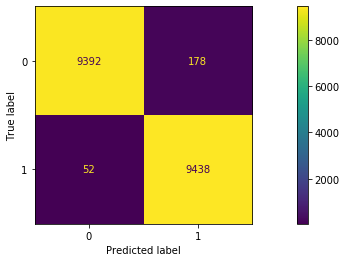

In [26]:
X_train_oven = X_train_oven[['load', 'hourofday', 'max', 'var', 'hurst']]
X_test_oven = X_test_oven[['load', 'hourofday', 'max', 'var', 'hurst']]

# create XGB object
XGB_oven = XGBClassifier()
# fit the model on training set
XGB_oven.fit(X_train_oven, y_train_oven)
# predcit the data on training set
y_pred_oven = XGB_oven.predict(X_train_oven)
# get the confusion matrix
matrix = confusion_matrix(y_train_oven, y_pred_oven)

print("F1 Score at training data: ", f1_score(y_train_oven, y_pred_oven, average=None))

print("\nConfusion Matrix for training data: \n", matrix)
print("\nON Testing SET-----------------------\n")

# predcit the data on testing set
y_pred_oven = XGB_oven.predict(X_test_oven)
# get the confusion matrix for testing set
matrix = confusion_matrix(y_test_oven, y_pred_oven)

print("F1 Score at testing data: ",f1_score(y_test_oven, y_pred_oven, average=None))

print("\nConfusion Matrix for testing data: \n",matrix)

plot_confusion_matrix(XGB_oven, X=X_test_oven, y_true= y_test_oven)

In [27]:
# Cross Validation
cv = KFold(n_splits=10)
n_scores = cross_val_score(XGB_oven, X_test_oven, y_test_oven, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('F1: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
print("Score for each validation and testing set", n_scores)

F1: 0.983 (0.003)
Score for each validation and testing set [0.98493506 0.9841756  0.98570672 0.980918   0.98010471 0.98338525
 0.97547684 0.98701299 0.98662551 0.98214286]


In [28]:
oven = XGB_oven.predict(df_test[['load', 'hourofday', 'max', 'var', 'hurst']])

In [29]:
a = XGB_oven.predict(df[['load', 'hourofday', 'max', 'var', 'hurst']])
print("F1 Score for all training data: ",f1_score(df['oven'], a, average=None))
matrix = confusion_matrix(df['oven'], a)
print("\nConfusion Matrix for all training data: \n", matrix)

F1 Score for all training data:  [0.99146237 0.62954304]

Confusion Matrix for all training data: 
 [[404824   6940]
 [    32   5924]]


### Training/Testing Data and SMOTE for Wash

In [30]:
# Training and testing data
X,Y = sample("wash",3)

X_sm, y_sm = sm.fit_resample(X, Y)

print("Dimension of X dataframe before SMOTE: {} \nDimension of X dataframe after SMOTE: {}".format(X.shape, X_sm.shape))

print('\npositive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

# split data in training and testing 80 training and 20 testing
X_train_wash, X_test_wash, y_train_wash, y_test_wash = train_test_split(X_sm,y_sm, test_size=0.2, random_state=13)

Dimension of X dataframe before SMOTE: (31812, 10) 
Dimension of X dataframe after SMOTE: (47718, 10)

positive and negative classes (%):


In [31]:
for i in range(1,len(X_train_wash.columns)):
    XGB_wash = XGBClassifier(eval_metric = 'logloss') 
    ac_fs = RFE(XGB_wash, n_features_to_select=i, step=1).fit(X_train_wash, y_train_wash)
    ac_fs.get_support()
    print(X_train_wash.columns[ac_fs.get_support()])
    
    ac_rf_pred = ac_fs.predict(X = X_test_wash)
    print(confusion_matrix(y_true = y_test_wash, y_pred = ac_rf_pred))

### XG Boost for Wash

[23:34:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 Score at training data:  [0.96666845 0.96802341]

Confusion Matrix for training data: 
 [[18068  1014]
 [  232 18860]]

ON Testing SET-----------------------

F1 Score at testing data:  [0.94582126 0.94829528]

Confusion Matrix for testing data: 
 [[4408  369]
 [ 136 4631]]


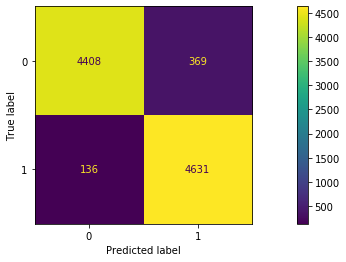

In [32]:
X_train_wash = X_train_wash[['load', 'hourofday', 'dayofweek', 'absdif', 'max', 'var', 'hurst']]
X_test_wash = X_test_wash[['load', 'hourofday', 'dayofweek', 'absdif', 'max', 'var', 'hurst']]


# create XGB object
XGB_wash = XGBClassifier()
# fit the model on training set
XGB_wash.fit(X_train_wash, y_train_wash)
# predcit the data on training set
y_pred_wash = XGB_wash.predict(X_train_wash)
# get the confusion matrix
matrix = confusion_matrix(y_train_wash, y_pred_wash)

print("F1 Score at training data: ", f1_score(y_train_wash, y_pred_wash, average=None))

print("\nConfusion Matrix for training data: \n", matrix)
print("\nON Testing SET-----------------------\n")

# predcit the data on testing set
y_pred_wash = XGB_wash.predict(X_test_wash)
# get the confusion matrix for testing set
matrix = confusion_matrix(y_test_wash, y_pred_wash)

print("F1 Score at testing data: ",f1_score(y_test_wash, y_pred_wash, average=None))

print("\nConfusion Matrix for testing data: \n",matrix)

plot_confusion_matrix(XGB_wash, X=X_test_wash, y_true= y_test_wash)

In [33]:
# Cross Validation
cv = KFold(n_splits=10)
n_scores = cross_val_score(XGB_wash, X_test_wash, y_test_wash, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('F1: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
print("Score for each validation and testing set", n_scores)

F1: 0.922 (0.010)
Score for each validation and testing set [0.94266278 0.93769799 0.92020725 0.90569948 0.91573604 0.91573604
 0.9219563  0.92082111 0.92214358 0.91859296]


In [34]:
wash = XGB_wash.predict(df_test[['load', 'hourofday', 'dayofweek', 'absdif', 'max', 'var', 'hurst']])

In [35]:
a = XGB_wash.predict(df[['load', 'hourofday', 'dayofweek', 'absdif', 'max', 'var', 'hurst']])
print("F1 Score for all training data: ",f1_score(df['wash'], a, average=None))
matrix = confusion_matrix(df['wash'], a)
print("\nConfusion Matrix for all training data: \n", matrix)

F1 Score for all training data:  [0.95781365 0.31802585]

Confusion Matrix for all training data: 
 [[376790  32977]
 [   214   7739]]


### Training/Testing Data and SMOTE for Dryer

In [36]:
# Training and testing data
X,Y = sample("dryer",3)

X_sm, y_sm = sm.fit_resample(X, Y)

print("Dimension of X dataframe before SMOTE: {} \nDimension of X dataframe after SMOTE: {}".format(X.shape, X_sm.shape))

print('\npositive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

# split data in training and testing 80 training and 20 testing
X_train_dryer, X_test_dryer, y_train_dryer, y_test_dryer = train_test_split(X_sm,y_sm, test_size=0.2, random_state=13)

Dimension of X dataframe before SMOTE: (54304, 10) 
Dimension of X dataframe after SMOTE: (81456, 10)

positive and negative classes (%):


In [37]:
for i in range(1,len(X_train_dryer.columns)):
    XGB_dryer = XGBClassifier(eval_metric = 'logloss') 
    ac_fs = RFE(XGB_dryer, n_features_to_select=i, step=1).fit(X_train_dryer, y_train_dryer)
    ac_fs.get_support()
    print(X_train_dryer.columns[ac_fs.get_support()])
    
    ac_rf_pred = ac_fs.predict(X = X_test_dryer)
    print(confusion_matrix(y_true = y_test_dryer, y_pred = ac_rf_pred))

### XG Boost for Dryer

[23:34:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 Score at training data:  [0.97529978 0.97613156]

Confusion Matrix for training data: 
 [[31233  1320]
 [  262 32349]]

ON Testing SET-----------------------

F1 Score at testing data:  [0.96524566 0.96647775]

Confusion Matrix for testing data: 
 [[7721  454]
 [ 102 8015]]


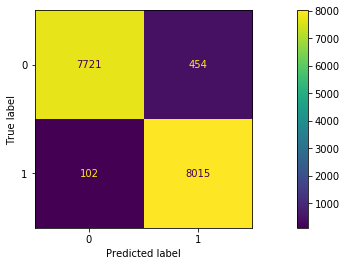

In [38]:
X_train_dryer = X_train_dryer[['load', 'hourofday', 'dayofweek', 'absdif', 'max', 'var', 'nonlinear','hurst']]
X_test_dryer = X_test_dryer[['load', 'hourofday', 'dayofweek', 'absdif', 'max', 'var', 'nonlinear','hurst']]

# create XGB object
XGB_dryer = XGBClassifier()
# fit the model on training set
XGB_dryer.fit(X_train_dryer, y_train_dryer)
# predcit the data on training set
y_pred_dryer = XGB_dryer.predict(X_train_dryer)
# get the confusion matrix
matrix = confusion_matrix(y_train_dryer, y_pred_dryer)

print("F1 Score at training data: ", f1_score(y_train_dryer, y_pred_dryer, average=None))

print("\nConfusion Matrix for training data: \n", matrix)
print("\nON Testing SET-----------------------\n")

# predcit the data on testing set
y_pred_dryer = XGB_dryer.predict(X_test_dryer)
# get the confusion matrix for testing set
matrix = confusion_matrix(y_test_dryer, y_pred_dryer)

print("F1 Score at testing data: ",f1_score(y_test_dryer, y_pred_dryer, average=None))

print("\nConfusion Matrix for testing data: \n",matrix)

plot_confusion_matrix(XGB_dryer, X=X_test_dryer, y_true= y_test_dryer)

In [39]:
# Cross Validation
cv = KFold(n_splits=10)
n_scores = cross_val_score(XGB_dryer, X_test_dryer, y_test_dryer, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('F1: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
print("Score for each validation and testing set", n_scores)

F1: 0.943 (0.004)
Score for each validation and testing set [0.93974437 0.94487255 0.94405594 0.95120517 0.94181818 0.93727811
 0.94492044 0.94656489 0.94228504 0.93562232]


In [40]:
dryer = XGB_dryer.predict(df_test[['load', 'hourofday', 'dayofweek', 'absdif', 'max', 'var', 'nonlinear','hurst']])

In [41]:
a = XGB_dryer.predict(df[['load', 'hourofday', 'dayofweek', 'absdif', 'max', 'var', 'nonlinear','hurst']])
print("F1 Score for all training data: ",f1_score(df['dryer'], a, average=None))
matrix = confusion_matrix(df['dryer'], a)
print("\nConfusion Matrix for all training data: \n", matrix)

F1 Score for all training data:  [0.97085515 0.53898339]

Confusion Matrix for all training data: 
 [[381432  22712]
 [   189  13387]]


#### Save the prediction result

In [42]:
col = {'id': Id, 'ac': ac_1, 'ev': ev, 'oven': oven, 'wash': wash, 'dryer': dryer}
final = pd.DataFrame(col)
final.to_csv('pred_labels.csv', index = False)